### Importing the  OASIS 2 Dataset: Longitudinal Demographics

In [1]:
import pandas as pd

data = pd.read_csv("~/code/mkvph0ch/memobrain/raw_data/OASIS2/oasis_longitudinal_demographics.csv")

data[:10]

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034
5,OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,F,R,88,18,3.0,28.0,0.0,1215,0.710,1.444
6,OAS2_0004,OAS2_0004_MR2,Nondemented,2,538,F,R,90,18,3.0,27.0,0.0,1200,0.718,1.462
7,OAS2_0005,OAS2_0005_MR1,Nondemented,1,0,M,R,80,12,4.0,28.0,0.0,1689,0.712,1.039
8,OAS2_0005,OAS2_0005_MR2,Nondemented,2,1010,M,R,83,12,4.0,29.0,0.5,1701,0.711,1.032
9,OAS2_0005,OAS2_0005_MR3,Nondemented,3,1603,M,R,85,12,4.0,30.0,0.0,1699,0.705,1.033


### Data cleaning
We check if there are any missing values in the dataset:

In [2]:
data.isnull().sum()

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

We create the prep_data function, that drops unneeded columns:
- 'MR Delay', 'Group' and 'Visit' (this temporary information does not apply to the analysis)
- 'Hand' (all patients are right handed)
- 'Subject ID', 'MRI ID' (they are just identification strings)

It fills empty values with the median in the case of 'SES' and 'MMSE' features. (Categorical values)

It also transforms the target column 'CDR' into binary class, dividing into Demented (some level) and Non Demented.

In [3]:
def prep_data(data):
    data=data.drop(columns=['MR Delay', 'Subject ID', 'MRI ID', 'Group', 'Visit', 'Hand'])
    data['SES'].fillna(value=int(data.SES.median()), inplace=True)
    data['MMSE'].fillna(value=int(data.MMSE.median()), inplace=True)
    data["CDR"]=data["CDR"].apply(lambda x: 1 if x>0 else 0)
    data["M/F"]=data["M/F"].apply(lambda x: 1 if x=='M' else 0)  
    return data

Then we split the data into X features and the y target.

In [4]:
X=prep_data(data).drop(columns=['CDR'])
y=prep_data(data)['CDR']
X

,M/F,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF
0,1,87,14,2.0,27.0,1987,0.696,0.883
1,1,88,14,2.0,30.0,2004,0.681,0.876
2,1,75,12,2.0,23.0,1678,0.736,1.046
3,1,76,12,2.0,28.0,1738,0.713,1.010
4,1,80,12,2.0,22.0,1698,0.701,1.034
...,...,...,...,...,...,...,...,...
368,1,82,16,1.0,28.0,1693,0.694,1.037
369,1,86,16,1.0,26.0,1688,0.675,1.040
370,0,61,13,2.0,30.0,1319,0.801,1.331
371,0,63,13,2.0,30.0,1327,0.796,1.323


EDUC: Level of Education (6 to 23)

SES: Socioeconomic Status (1 to 5)

MMSE: Mini-Mental State Examination (4 to 30)

eTIV: Estimated total intracranial volume (mm3)

nWBV: Normalized whole brain volume

ASF: Atlas scaling factor

<AxesSubplot:>

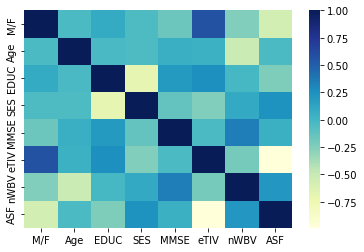

In [5]:
import seaborn as sns

corr = X.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap= "YlGnBu")

In [7]:
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
import numpy as np

log_model = LogisticRegression(max_iter=200).fit(X, y)

permutation_score = permutation_importance(log_model, X, y, n_repeats=10) 

importance_df = pd.DataFrame(np.vstack((X.columns,permutation_score.importances_mean)).T)

importance_df.columns=['feature','score decrease']

importance_df.sort_values(by="score decrease", ascending = False)

,feature,score decrease
4,MMSE,0.238874
7,ASF,0.05067
0,M/F,0.027882
5,eTIV,0.01555
1,Age,-0.001877
2,EDUC,-0.001877
3,SES,-0.002681
6,nWBV,-0.003753


### Pipeline
We create a pipeline with all the transformations that will be applied to the data set, including scaling and encoding.

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn import set_config; set_config(display='diagram')
from sklearn.pipeline import Pipeline

preproc = ColumnTransformer([
    ('s_scaler', StandardScaler(), ['Age']),
    ('m_scaler', MinMaxScaler(), ['EDUC']),
    ('r_scaler', RobustScaler(), ['eTIV', 'MMSE'])],
    remainder='passthrough')

preproc

ColumnTransformer(remainder='passthrough',
                  transformers=[('s_scaler', StandardScaler(), ['Age']),
                                ('m_scaler', MinMaxScaler(), ['EDUC']),
                                ('r_scaler', RobustScaler(), ['eTIV', 'MMSE'])])

In [11]:
oasis2_scaled=pd.DataFrame(preproc.fit_transform(X,y), columns = preproc.get_feature_names_out())
oasis2_scaled

,s_scaler__Age,m_scaler__EDUC,r_scaler__eTIV,r_scaler__MMSE,remainder__M/F,remainder__SES,remainder__nWBV,remainder__ASF
0,1.308738,0.470588,2.154167,-0.666667,1.0,2.0,0.696,0.883
1,1.439787,0.470588,2.225000,0.333333,1.0,2.0,0.681,0.876
2,-0.263856,0.352941,0.866667,-2.000000,1.0,2.0,0.736,1.046
3,-0.132806,0.352941,1.116667,-0.333333,1.0,2.0,0.713,1.010
4,0.391392,0.352941,0.950000,-2.333333,1.0,2.0,0.701,1.034
...,...,...,...,...,...,...,...,...
368,0.653491,0.588235,0.929167,-0.333333,1.0,1.0,0.694,1.037
369,1.177688,0.588235,0.908333,-1.000000,1.0,1.0,0.675,1.040
370,-2.098548,0.411765,-0.629167,0.333333,0.0,2.0,0.801,1.331
371,-1.836449,0.411765,-0.595833,0.333333,0.0,2.0,0.796,1.323


\
Renaming the column labels that were modified while applying the pipeline.

In [12]:
oasis2_scaled = oasis2_scaled.rename(columns={"s_scaler__Age": "scaled_age",
                              "m_scaler__EDUC": "scaled_educ",
                              "r_scaler__eTIV": "scaled_eTIV",
                              "r_scaler__MMSE": "scaled_MMSE",
                              "remainder__M/F": "Male",
                              "remainder__SES": "SES",
                              "remainder__nWBV": "nWBV",
                              "remainder__ASF": "ASF"})

oasis2_scaled

,scaled_age,scaled_educ,scaled_eTIV,scaled_MMSE,Male,SES,nWBV,ASF
0,1.308738,0.470588,2.154167,-0.666667,1.0,2.0,0.696,0.883
1,1.439787,0.470588,2.225000,0.333333,1.0,2.0,0.681,0.876
2,-0.263856,0.352941,0.866667,-2.000000,1.0,2.0,0.736,1.046
3,-0.132806,0.352941,1.116667,-0.333333,1.0,2.0,0.713,1.010
4,0.391392,0.352941,0.950000,-2.333333,1.0,2.0,0.701,1.034
...,...,...,...,...,...,...,...,...
368,0.653491,0.588235,0.929167,-0.333333,1.0,1.0,0.694,1.037
369,1.177688,0.588235,0.908333,-1.000000,1.0,1.0,0.675,1.040
370,-2.098548,0.411765,-0.629167,0.333333,0.0,2.0,0.801,1.331
371,-1.836449,0.411765,-0.595833,0.333333,0.0,2.0,0.796,1.323


\
We now split the data into train and test set.

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(oasis2_scaled, y, test_size=0.25, random_state=42)

### Choosing the right estimator

We will look now for the right estimator to solve this machine learning problem. Since we have a dataset size between 50 and 100k samples, and target is categorical, we will start with the Linear Support Vector Classification (SVC) estimator.



We will do GridSearch to find the best parameters on each model, scoring on "recall". This because we want to identify all the positive samples, in this case, the patients with dementia.

#### Linear SVC

In [16]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

model_lsvc = LinearSVC()

parameters = {'penalty':['l1', 'l2'],
              'C': [0.1, 1, 10, 100, 1000, 10000]}

gridsearch1 = GridSearchCV(model_lsvc,
                          parameters,
                          n_jobs=-1,
                          cv=5,
                          scoring="recall")

gridsearch1.fit(X_train, y_train)

/home/vicente/.pyenv/versions/3.8.12/envs/memobrain/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/home/vicente/.pyenv/versions/3.8.12/envs/memobrain/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vicente/.pyenv/versions/3.8.12/envs/memobrain/lib/python3.8/site-packages/sklearn/svm/_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/home/vicente/.pyenv/versions/3.8

GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000, 10000],
                         'penalty': ['l1', 'l2']},
             scoring='recall')

In [57]:
gridsearch1.best_params_

{'C': 10000, 'penalty': 'l2'}

In [58]:
gridsearch1.best_score_

0.7646666666666666

In [59]:
model_lsvc_best = LinearSVC(penalty= "l2", C= 10000)
model_lsvc_best.fit(X_train, y_train)

/home/vicente/.pyenv/versions/3.8.12/envs/memobrain/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=10000)

\
Now we will predict the target:

In [60]:
y_pred1 = model_lsvc_best.predict(X_test)

In [61]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred1)

0.9318181818181818

#### KNeighbors Classifier

In [24]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier()

parameters = {'n_neighbors': range(1,10)}

gridsearch2 = GridSearchCV(knc,
                          parameters,
                          n_jobs=-1,
                          cv=5,
                          scoring="recall")

gridsearch2.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(1, 10)}, scoring='recall')

In [25]:
gridsearch2.best_params_

{'n_neighbors': 1}

In [26]:
gridsearch2.best_score_

0.7556666666666667

In [27]:
model_knc_best = KNeighborsClassifier(n_neighbors= 1)
model_knc_best.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [28]:
y_pred2 = model_knc_best.predict(X_test)

In [48]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred2)

0.8636363636363636

#### SVC

In [31]:
from sklearn.svm import SVC

model_svc = SVC()

parameters = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
              'C': [1, 10, 100, 1000, 10000, 100000]}

gridsearch3 = GridSearchCV(model_svc,
                          parameters,
                          n_jobs=-1,
                          cv=5,
                          scoring="recall")

gridsearch3.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000, 10000, 100000],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='recall')

In [32]:
gridsearch3.best_params_

{'C': 100000, 'kernel': 'poly'}

In [33]:
gridsearch3.best_score_

0.749

In [34]:
model_svc_best = SVC(kernel='poly', C=100000)
model_svc_best.fit(X_train, y_train)

SVC(C=100000, kernel='poly')

In [35]:
y_pred3 = model_svc_best.predict(X_test)

In [49]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred3)

0.75

#### Decision Tree

We will create now a Decision Tree, to break down the data through binary decisions.

In [39]:
from sklearn.tree import DecisionTreeClassifier

parameters = {'criterion': ['gini', 'entropy'],
              'max_depth': range(1,10),
              'min_samples_leaf': range(1,10),
              'min_samples_split': range(2,10)}
gridsearch4 = GridSearchCV(DecisionTreeClassifier(),
                          parameters,
                          n_jobs=-1,
                          cv=5,
                          scoring="recall")

gridsearch4.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 10),
                         'min_samples_split': range(2, 10)},
             scoring='recall')

In [40]:
gridsearch4.best_params_

{'criterion': 'entropy',
 'max_depth': 7,
 'min_samples_leaf': 3,
 'min_samples_split': 3}

In [41]:
gridsearch4.best_score_

0.765

In [42]:
tree_clf = DecisionTreeClassifier(criterion= 'entropy', max_depth=7, min_samples_leaf= 3, min_samples_split= 3)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=3,
                       min_samples_split=3)

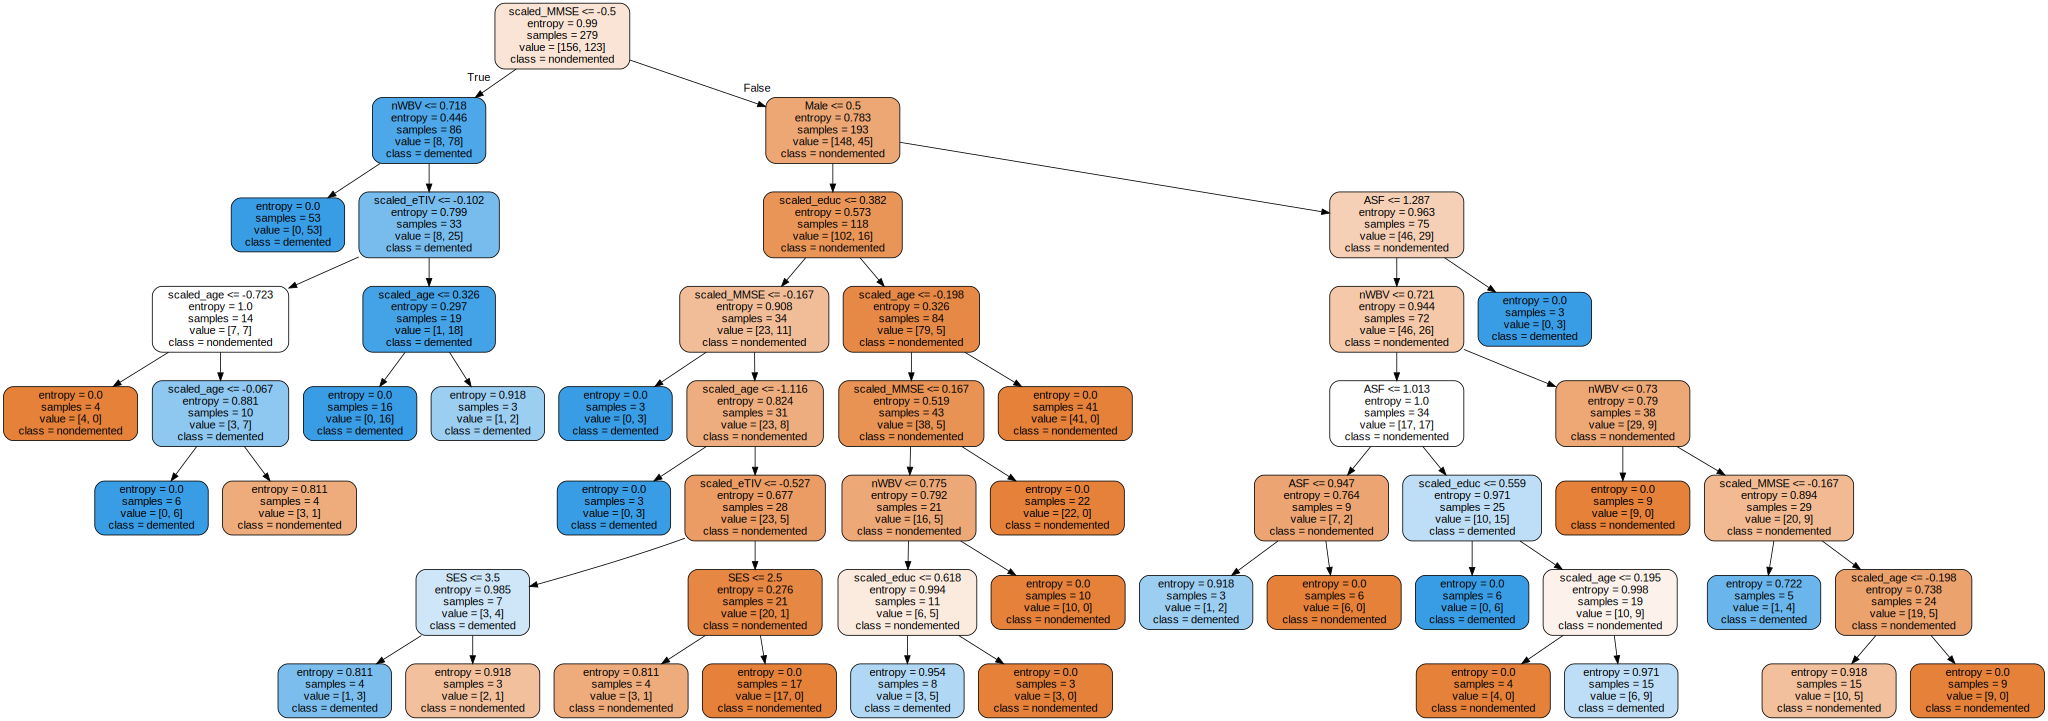

In [44]:
import graphviz

from sklearn.tree import export_graphviz
export_graphviz(tree_clf, out_file="dt.dot", 
                feature_names=X_train.columns,
                class_names=['nondemented','demented'], 
                rounded=True, filled=True)

with open("dt.dot") as f:
    dot_graph = f.read()
    display(graphviz.Source(dot_graph))

In [45]:
y_pred4 = tree_clf.predict(X_test)

In [50]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred4)

0.7272727272727273